## SVM Classifier on Concrete Image Data
Possible labels are C for Cracked (Positive) and U for Uncracked
This will load the dataset via wget but it can also be downloaded manually

In [50]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import PIL
import random
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, f1_score, make_scorer, confusion_matrix
from collections import defaultdict
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from time import time, perf_counter, perf_counter_ns
from sklearn.svm import SVC
from os import listdir
from joblib import dump, load

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Download and unzip the dataset from
https://digitalcommons.usu.edu/context/all_datasets/article/1047/type/native/viewcontent

In [51]:
### Only run if you re-downloaded the files and need to process them into memory
data_path = "./DATA_Maguire_20180517_ALL/SDNET2018/"
cracked_labels = set()
labels = []
image_files = []
structures = ["D", "P", "W"]
for structure in structures:
    for label in ["U", "C"]:
        img_folder = data_path + structure + "/" + label + structure
        for filename in listdir(img_folder):
            if filename.endswith("jpg"):
                image_file = img_folder + "/" + filename
                image_files.append(image_file)
                labels.append(label)
            else:
                print("bad name -> " + filename)



In [52]:
#Only run to update the train/test split
X_train_files, X_test_files, y_train, y_test = train_test_split(image_files, labels, test_size=0.75)
#to get a smaller test set for submission purposes
X_validation_files, X_test_files, y_validation_files, y_test = train_test_split(X_test_files, y_test, test_size=0.1)

In [53]:
def loadAndScaleImages(filelist):
  print("loadAndScaleImages")
  imgdata = []
  i = 0
  #kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
  start = perf_counter()
  for file in filelist:
    data = cv2.imread(file)
    #data = convImage(data, np.array([[1,0,0,1],[0,1,1,0],[0,1,1,0],[1,0,0,1]]), 2)
    #data = convImage(data, kernel, 3)
    data = convImageLap(data)
    imgdata.append(data.flatten())
    i = i + 1
    if i % 500 == 0:
      batch_end = perf_counter()
      print(i, "images completed out of", len(filelist), "in", (batch_end - start), "s")
      start = batch_end
  return np.array(imgdata)

def runPCA(X, n_c, plot=False):
  print("Running PCA")
  pca = PCA(n_components=n_c)
  pca.fit(X)
  if(plot):
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
  return pca

def scaleData(X, scaler=None):
  if scaler == None:
    scaler = StandardScaler(copy=False)
    scaler.fit(X)
  scaler.transform(X, copy=False)
  return scaler

#custom code to apply kernel
#switched to using cv2 built in filters
def convImage(image, kernel, stride):
  #assume a square for image and kernel
  k_w = kernel.shape[0]
  i_w = image.shape[1]
  #k_center = (k_w - 1)/2
  #k_iter_range = range(k_center, i_w - k_center, stride)
  k_iter_range = range(0, i_w - k_w, stride)
  output = np.zeros((len(k_iter_range), len(k_iter_range)))
  for iy, y in enumerate(k_iter_range):
    for ix, x in enumerate(k_iter_range):
      output[ix,iy] = (kernel * image[x:x+k_w, y:y+k_w]).sum()
  output[:2]
  return output

def convImageLap(image, useSobel=False):
  #convert to grayscale
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #scale the image by 50%
  h_w = int(img.shape[0] * 0.5)
  img = cv2.resize(img, (h_w, h_w))
  # Reduce noise in image
  img = cv2.GaussianBlur(img,(3,3),0)
  filtered_image = None
  if useSobel == True:
    #Use an x/y gradient Sobel filter to detect edges
    grad_x = cv2.Sobel(img, dx=1, dy=0, ksize=3, ddepth=cv2.CV_16S)
    grad_y = cv2.Sobel(gray, dx=0, dy=1, ksize=3, ddepth=cv2.CV_16S)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)  
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
  else:
    #default to Laplacian Edge Detector
    filtered_image = cv2.Laplacian(img, ksize=3, ddepth=cv2.CV_16S)
    # converting back to uint8
    filtered_image = cv2.convertScaleAbs(filtered_image)
  return filtered_image

In [20]:
def getFileNames(version=""):
  path = ""
  if version != "":
    version = "_" + version
  return (path + "PCA" + version, path + "SVC" + version, path + "XY_Train" + version, path + "XY_Test" + version)

def loadTrainTest(fn):
  npz = np.load(fn + ".npz")
  X = npz[npz.files[0]]
  Y = npz[npz.files[1]]
  return (X,Y)

def saveData(pca=None, train=None, test=None, svc=None, version=""):
  (pca_fn, svc_fn, train_fn, test_fn) = getFileNames(version)
  if(train != None):
    print("saving train to", train_fn)
    (X_train, y_train) = train
    np.savez(train_fn, X_train, y_train)
  if(test != None):
    print("saving test to", test_fn)
    (X_test, y_test) = test
    np.savez(test_fn, X_test, y_test)
  if(pca != None):
    print("saving pc to", pca_fn)
    dump(pca, pca_fn + ".joblib")
  if(svc != None):
    print("saving svc to", svc_fn)
    dump(svc, svc_fn + ".joblib")

def loadData(load_test=True, load_train=True, load_pca=True, load_svc=True, version=""):
  (pca_fn, svc_fn, train_fn, test_fn) = getFileNames(version)
  pca = X_train = y_train = X_test = y_test = np.zeros(0)
  if load_pca == True:
    pca = load(pca_fn + '.joblib')
  if load_svc == True:
    svc = load(svc_fn + '.joblib')
  if load_train == True:
    (X_train, y_train) = loadTrainTest(train_fn)
  if load_test == True:
    (X_test, y_test) = loadTrainTest(test_fn)
  return (pca, X_train, y_train, X_test, y_test)

def plotConfusion(svc, X,y):
  plot_confusion_matrix(svc, X, y,
                              cmap=plt.cm.Blues,
                              labels=['C','U'])
  plt.show()

In [54]:
#run if changing the training data
X_train = loadAndScaleImages(X_train_files)
std = scaleData(X_train)

loadAndScaleImages
500 images completed out of 14023 in 1.3270877679997284 s
1000 images completed out of 14023 in 1.09217529200032 s
1500 images completed out of 14023 in 1.2114062740001827 s
2000 images completed out of 14023 in 1.0837019919999875 s
2500 images completed out of 14023 in 1.6511037109994504 s
3000 images completed out of 14023 in 1.0539988930004256 s
3500 images completed out of 14023 in 1.3297656269996878 s
4000 images completed out of 14023 in 1.7815641480001432 s
4500 images completed out of 14023 in 1.1093671429998722 s
5000 images completed out of 14023 in 2.644621807000476 s
5500 images completed out of 14023 in 1.1278144569996584 s
6000 images completed out of 14023 in 1.1329412420000153 s
6500 images completed out of 14023 in 1.2198829260005368 s
7000 images completed out of 14023 in 1.066000382999846 s
7500 images completed out of 14023 in 1.0559777700000268 s
8000 images completed out of 14023 in 1.0789966729998923 s
8500 images completed out of 14023 in 1.04

Running PCA


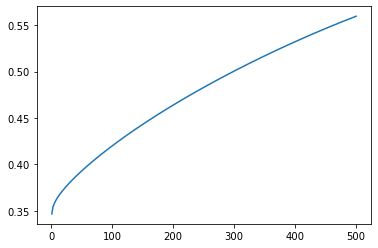

In [55]:
pca = runPCA(X_train, 500, True)

In [ ]:
# skip to here and run if doing initial GridSearchCV
print("Fitting the classifier to the training set")
X_train_pca = pca.transform(X_train)
param_grid = {
         'C': [0.01, 1, 100],
          'gamma': [0.0001, 0.001, 0.1],
          'kernel': ['rbf', 'sigmoid']
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=3, cv=2, scoring=make_scorer(f1_score, pos_label='C'))
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.006, total= 1.2min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.005, total= 1.2min
[CV] C=1, gamma=0.0001, kernel=sigmoid ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] ... C=1, gamma=0.0001, kernel=sigmoid, score=0.257, total=  12.7s
[CV] C=1, gamma=0.0001, kernel=sigmoid ...............................
[CV] ... C=1, gamma=0.0001, kernel=sigmoid, score=0.228, total=  12.9s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.000, total=  53.5s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.000, total=  53.1s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ...... C=1, gamma=0.1, kernel=sigmoid, score=0.256, total=  12.5s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ...... C=1, gamma=0.1, kernel=sigmoid, score=0.238, total=  12.4s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.005, total= 1.4min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 10.9min finished


Best estimator found by grid search:
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [56]:
X_train_pca = pca.transform(X_train)
svc = SVC(kernel='sigmoid', class_weight='balanced', C=0.001, gamma=0.01, cache_size=5000)
svc.fit(X_train_pca, y_train)
y_train_pred = svc.predict(X_train_pca)
f1 = f1_score(y_train, y_train_pred, pos_label='C')
print("F1 Score ->", f1)
conf = confusion_matrix(y_train, y_train_pred, labels=['U','C'])
print(conf)
saveData(pca=pca, train=(X_train, y_train), svc=svc, version="small")

F1 Score -> 0.28071428571428575
[[4395 7474]
 [ 582 1572]]
saving train to XY_Train_small
saving pc to PCA_small
saving svc to SVC_small


In [57]:
X_test = loadAndScaleImages(X_test_files)
scaleData(X_test, scaler=std)
X_test_pca = pca.transform(X_test)
y_pred = svc.predict(X_test_pca)
f1 = f1_score(y_test, y_pred, pos_label='C')
print("F1 Score ->", f1)
conf = confusion_matrix(y_test, y_pred, labels=['U','C'])
print(conf)
saveData(test=(X_test, y_test), version="small")

loadAndScaleImages
500 images completed out of 4207 in 1.3255264859999443 s
1000 images completed out of 4207 in 1.1792247140001564 s
1500 images completed out of 4207 in 1.4966283109997676 s
2000 images completed out of 4207 in 3.580255508999471 s
2500 images completed out of 4207 in 2.766042787000515 s
3000 images completed out of 4207 in 1.0618580820000716 s
3500 images completed out of 4207 in 1.05674702899978 s
4000 images completed out of 4207 in 1.0712722239995855 s
F1 Score -> 0.284398388025331
[[1227 2310]
 [ 176  494]]
saving test to XY_Test_small


In [60]:
report = metrics.classification_report(y_test, y_pred, labels=['U','C'])
print(report)

              precision    recall  f1-score   support

           U       0.87      0.35      0.50      3537
           C       0.18      0.74      0.28       670

    accuracy                           0.41      4207
   macro avg       0.53      0.54      0.39      4207
weighted avg       0.76      0.41      0.46      4207



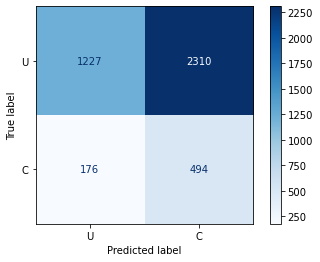

In [61]:
conf = confusion_matrix(y_test, y_pred, labels=['U','C'])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['U','C'])
disp.plot(cmap=plt.cm.Blues)

In [ ]:
def plot_gallery(images, titles,w,h, n_row=1, n_col=5, offset=0):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2.8 * n_col, 3.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        
        plt.subplot(n_row, n_col, i + 1)
        i = offset + i
        plt.imshow(images[i].reshape(w,h), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

['W/UW/7106-35.jpg', 'P/UP/056-43.jpg', 'W/UW/7136-85.jpg', 'W/UW/7089-145.jpg', 'P/CP/009-20.jpg']


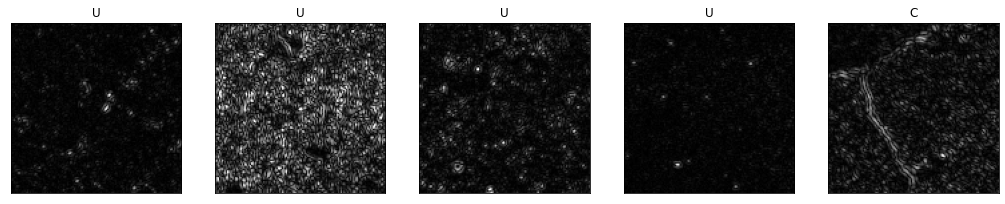

In [ ]:
# Plot images representing the results of edge detection
randIdx = random.randint(0,5000)
offset=5
plot_gallery(X_train[randIdx:randIdx+offset], y_train[randIdx:randIdx+offset], 128,128)
print(X_train_files[randIdx:randIdx+offset])